In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Package Setup**

In [ ]:
!pip install keras-bert

###**Tensorflow Configuration**

We setup an environment variable for keras-bert to use tensorflow.python.keras

In [ ]:
import os
os.environ['TF_KERAS'] = '1'    # Required to use tensorflow.python.keras with keras-bert

In [ ]:
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split

###**Settingup GPU**

In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
    print('We will use the GPU:', device_name)
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0
We will use the GPU: /device:GPU:0


###**Load Train and Test Data**

In [ ]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_file.txt', sep='{}{}{}', engine = 'python')
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test_file.txt", sep= '{}{}{}', engine = 'python')

#from sklearn.model_selection import train_test_split

train, val =  train,test

###**Download Pretrained BERT Model**
Here I have downloaded the Large Cased trained model

In [ ]:
# Give -nc (--no-clobber) argument so that the file isn't downloaded multiple times 
!wget -nc https://storage.googleapis.com/bert_models/2018_10_18/cased_L-12_H-768_A-12.zip

File ‘cased_L-12_H-768_A-12.zip’ already there; not retrieving.



In [ ]:
# Give -n argument so that existing files aren't overwritten 
!unzip -n cased_L-12_H-768_A-12.zip

Archive:  cased_L-12_H-768_A-12.zip


- vocab.txt is a plain file listing vocabulary items 
- bert_config.json consists of model configuration in JSON format
- bert_model.ckpt.* consists of model checkpoint data with pretrained weights

In [ ]:
bert_vocab_path = 'cased_L-12_H-768_A-12/vocab.txt'
bert_config_path = 'cased_L-12_H-768_A-12/bert_config.json'
bert_checkpoint_path = 'cased_L-12_H-768_A-12/bert_model.ckpt'    # suffixes not required


Make sure if the model we downloaded was case sensitive or not

In [ ]:
model_is_cased = True

Shuffle the data to avoid bias

In [ ]:
from sklearn.utils import shuffle

train = shuffle(train)
train.head()

,Label,Text
6416,__label__ne,"""Peter Hustinx, EDPS, says: ""Cloud computing c..."
3711,__label__ne,Austrian village wants to change name from cur...
7235,__label__pb,". Thursday, October 27, 2011 I didn't think ..."
4103,__label__ne,The couple who were red zoned twice GUTTED: A...
7401,__label__pb,"I'm a PhD dropout, and I'm not ashamed to admi..."


###**Load BERT Vocabulary**
A plain text file with one vocabulary item per line

In [ ]:
vocab = []
with open(bert_vocab_path) as f:
    for i, line in enumerate(f):
        vocab.append(line.rstrip('\n'))    # rstrip to remove newline characters


# Print a list with every 500th vocabulary item
print(vocab[0::500])
print(len(vocab))

['[PAD]', 'щ', '吉', 'told', 'space', 'operations', 'proposed', 'Oxford', 'showing', 'domestic', 'mountains', 'commission', 'voices', 'associate', 'hills', 'Guide', 'relaxed', 'Page', 'Heights', 'singers', 'Interior', 'considers', 'facilitate', 'shouting', '1826', 'constitute', 'alter', 'clip', 'Into', 'Memory', 'ballad', 'Owens', 'Langdon', 'aquatic', 'stereo', 'Cass', 'Shock', '195', '##tec', '##sonic', 'attested', '##rdes', '1840s', '##90', 'Guys', '##rien', 'Munro', 'Ursula', 'mesh', 'diplomacy', 'Newmarket', '##oughs', 'synthesizers', 'Drugs', 'monstrous', '##ynamic', 'troll', '##ٹ']
28996


###**Load BERT Configuration File**
The configuration is just a json file so we use json.load from python json library. We wont actually need to use these configuration details directly (keras-bert takes care of them for us). Lets see what information is contained in the config file. 

In [ ]:
from pprint import pprint    # pretty-printer for output
import json

with open(bert_config_path) as f:
    config = json.load(f)


# Print configuration contents
pprint(config)

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 28996}


###**Create BERT Tokenizer**

To create the tokenizer, we'll need mapping from vocabulary items to their integer indices. 

In [ ]:
import random
# Create mapping from vocabulary items to their indices in the vocabulary
token_dict = { v: i for i, v in enumerate(vocab) }


# Print some random examples of the mapping
pprint(dict(random.choices(list(token_dict.items()), k=10)))

{'##grounds': 26171,
 '##phy': 22192,
 'Editorial': 23640,
 'Market': 6923,
 'citizenship': 9709,
 'earl': 26593,
 'hemisphere': 24114,
 'prince': 6927,
 'record': 1647,
 'spreads': 23237}


We'll use the keras-bert Tokenizer for BERT tokenization. The implementation supports

- (Optional) lowercasing: Hello → hello
- Basic tokenization: Hello! → Hello !, multi-part → multi - part
- Wordpiece tokenization: comprehensively → comprehensive ##ly
- Adding special tokens: Sentence → [CLS] Sentence [SEP]
- Mapping to integer indices
- Generating segment sequence
- (Optional) padding and truncation to length

In the following example, notice how words not in the dictionary are broken up into subwords (with continuation parts starting with ##) and how unknown characters are mapped to a special unknown word token [UNK].



In [ ]:
from keras_bert import Tokenizer


tokenizer = Tokenizer(token_dict, cased=model_is_cased)


# Let's test that out
for s in ['Hello BERT!', 'Unknown: unknown 你']:
    print('Original string:', s)
    print('Tokenized:', tokenizer.tokenize(s))
    indices, segments = tokenizer.encode(s, max_len=20)    # max_len for padding and truncation
    print('Encoded:', indices)
    print('Segments:', segments)
    print('Decoded:', ' '.join(tokenizer.decode(indices)))
    print()

Original string: Hello BERT!
Tokenized: ['[CLS]', 'Hello', 'B', '##ER', '##T', '!', '[SEP]']
Encoded: [101, 8667, 139, 9637, 1942, 106, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Hello B ##ER ##T !

Original string: Unknown: unknown 你
Tokenized: ['[CLS]', 'Unknown', ':', 'unknown', '你', '[SEP]']
Encoded: [101, 16285, 131, 3655, 100, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Segments: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Decoded: Unknown : unknown [UNK]



In [ ]:
# max_le = 0
# i = 0
# for i, document in enumerate (train['Text'].values):
#   tokenized = tokenizer.tokenize(document)
#   document_length = len(tokenized)

#   if document_length > max_le:

#     max_le = document_length
#     i = i

# print(max)
# print(i)

In [ ]:
#print(train['Text'].values[17587])
len(tokenizer.tokenize(train['Text'].values[17587]))

1297

In [ ]:
train.head()
train['Label'].values

array(['__label__ne', '__label__ne', '__label__pb', ..., '__label__ne',
       '__label__rv', '__label__ne'], dtype=object)

###**Vectorize data**
We'll use the  LabelEncoder for labels and the keras-bert Tokenizer for text data. Y is the representation of the labels that will be given to the model for training.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels =train['Label'].values
label_encoder = LabelEncoder()    # Turns class labels into integers
Y = label_encoder.fit_transform(labels)

# Take note of how many unique labels there are in the data
num_labels = len(set(Y))


# Print out some examples
print('Number of unique labels:', num_labels)
print(type(labels), labels[:10])
print(type(Y), Y[:10])

Number of unique labels: 26
<class 'numpy.ndarray'> ['__label__ne' '__label__ne' '__label__pb' '__label__ne' '__label__pb'
 '__label__dt' '__label__dt' '__label__sr' '__label__rv' '__label__ha']
<class 'numpy.ndarray'> [12 12 14 12 14  4  4 22 20  8]


In [ ]:
y_val = label_encoder.fit_transform(test['Label'].values)

Keep token indices and segment ids in separate lists and store as numpy arrays. X here is the final vectorized form of the input we'll be providing to the model for training.

In [ ]:
import numpy as np


train_token_indices, train_segment_ids = [], []  #bert tokenizer indices and their segment ids  (to separate sequences)
val_token_indices, val_segment_ids = [], []
for text in train['Text'].values:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    ttid, tsid = tokenizer.encode(text, max_len=256)
    train_token_indices.append(ttid)
    train_segment_ids.append(tsid)

for text in test['Text'].values:
    # tokenizer.encode() returns a sequence of token indices
    # and a sequence of segment IDs. BERT expects both as input,
    # even if the segments IDs are just all zeros (like here).
    vtid, vsid = tokenizer.encode(text, max_len=256)
    val_token_indices.append(vtid)
    val_segment_ids.append(vsid)

# Format input as list of two numpy arrays
train_X = [np.array(train_token_indices), np.array(train_segment_ids)]
val_X = [np.array(val_token_indices), np.array(val_segment_ids)]


# Print some examples
# print('Token indices:')
# print(val_X[0][:2])
# print('Decoded:')
# for i in val_X[0][:2]:
#     print(tokenizer.decode(list(i)))
# print('Segment ids:')
# print(val_X[1][:2])
# print()
# print()

# print('Token indices:')
# print(train_X[0][:2])
# print('Decoded:')
# for i in train_X[0][:2]:
#     print(tokenizer.decode(list(i)))
# print('Segment ids:')
# print(train_X[1][:2])


In [ ]:
# label_encode = {}
# for i, v  in enumerate(train['Label'].unique()):
#   label_encode[v] = i
# label_encode

In [ ]:
# train['Label_enc'] = train['Label'].map(label_encode)
# val['Label_enc'] = val['Label'].map(label_encode)
# val.head()

In [ ]:
from keras_bert import load_trained_model_from_checkpoint


pretrained_model = load_trained_model_from_checkpoint(
    config_file = bert_config_path,
    checkpoint_file = bert_checkpoint_path,
    training = False,
    trainable = True,
    seq_len = 256
)

In [ ]:
# This is a keras model, so we can figure out what inputs it takes like so:
pretrained_model.inputs

[<tf.Tensor 'Input-Token_1:0' shape=(None, 256) dtype=float32>,
 <tf.Tensor 'Input-Segment_1:0' shape=(None, 256) dtype=float32>]

In [ ]:
# And similarly for outputs:
pretrained_model.outputs

[<tf.Tensor 'Encoder-12-FeedForward-Norm/add_3:0' shape=(None, 256, 768) dtype=float32>]

In [ ]:
#@title Default title text

pretrained_model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 256)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 256)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 256, 768), ( 22268928    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 256, 768)     1536        Input-Segment[0][0]              
_______________________________________________________________________________________

In [ ]:
# model.outputs is a list, here with a single item. Here
# pretrained_model.outputs[0] just grabs that item (the output tensor).
# Indxing that tensor with [:,0] gives the first position in the sequence
# for all elements in the batch (the `:`).
bert_out = pretrained_model.outputs[0][:,0]

print(bert_out)

Tensor("strided_slice_1:0", shape=(None, 768), dtype=float32)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
#num_labels = 26

dropout_layer = Dropout(.5, input_shape=(768,))(bert_out)
out = Dense(num_labels, activation='softmax')(dropout_layer)
model = Model(
    inputs=pretrained_model.inputs,
    outputs=[out]
)

In [ ]:
from keras_bert import calc_train_steps, AdamWarmup


# Calculate the number of steps for warmup
total_steps, warmup_steps = calc_train_steps(
    num_example=len(train['Text'].values),
    batch_size=8,
    epochs=3,
    warmup_proportion=0.1,
)

optimizer = AdamWarmup(
    total_steps,
    warmup_steps,
    lr=0.00002,
    epsilon=1e-6,
    weight_decay=0.01,
    weight_decay_pattern=['embeddings', 'kernel', 'W1', 'W2', 'Wk', 'Wq', 'Wv', 'Wo']
)

In [ ]:
from keras.metrics import sparse_categorical_accuracy
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/assets')
history = model.fit(
    train_X,
    Y,
    epochs=3,
    batch_size=8,
    validation_data= (val_X,y_val)
    
)

Epoch 1/3
2199/2199 [==============================] - 1761s 801ms/step - loss: 1.4084 - sparse_categorical_accuracy: 0.6091 - val_loss: 0.9177 - val_sparse_categorical_accuracy: 0.7344
Epoch 2/3
2199/2199 [==============================] - 1749s 795ms/step - loss: 0.6884 - sparse_categorical_accuracy: 0.7948 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.7670
Epoch 3/3
2199/2199 [==============================] - 1744s 793ms/step - loss: 0.4038 - sparse_categorical_accuracy: 0.8764 - val_loss: 0.8591 - val_sparse_categorical_accuracy: 0.7683


In [ ]:
train_X

[array([[  101,   107,  1943, ...,   131,  3341,   102],
        [  101,  5488,  1491, ...,  1186,   117,   102],
        [  101,   119,  9170, ...,  1146,   117,   102],
        ...,
        [  101, 18911,   143, ...,     0,     0,     0],
        [  101,   139, 13791, ...,     0,     0,     0],
        [  101,  1109, 14901, ..., 12636,  1107,   102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
# os.chdir('/content/drive/My Drive/Colab Notebooks/')
# os.getcwd()
# !ls

In [ ]:
# #!pip install numba 
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

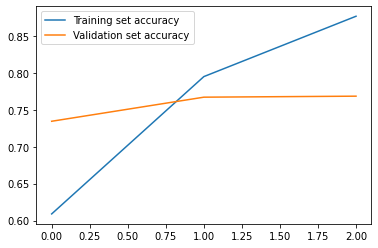

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt



def plot_history(history):
    plt.plot(history.history['sparse_categorical_accuracy'],label="Training set accuracy")
    plt.plot(history.history['val_sparse_categorical_accuracy'],label="Validation set accuracy")
    plt.legend()
    plt.show()


plot_history(history)

In [ ]:
model.evaluate(val_X,y_val)


70/70 [==============================] - 44s 631ms/step - loss: 0.8591 - sparse_categorical_accuracy: 0.7683


[0.85907381772995, 0.7683258056640625]

In [ ]:
val_X[:2]

[array([[  101,  2066,  1330, ...,     0,     0,     0],
        [  101,  2009,  2033, ...,  2638,  2231,   102],
        [  101,  1332,  1234, ...,  8658,  1103,   102],
        ...,
        [  101, 21300,  1447, ...,  1234, 14884,   102],
        [  101,  7993,  1240, ...,   146,  5782,   102],
        [  101,  1188,  3674, ...,  1234,  1132,   102]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])]

In [ ]:
a = model.predict([val_X[0][:5], val_X[1][:5]])
a

array([[6.35013869e-03, 7.43028359e-04, 2.95069447e-04, 2.13022646e-03,
        2.69028284e-02, 4.15252987e-04, 8.92208598e-04, 2.31711473e-03,
        8.88575451e-04, 5.53901133e-04, 9.15635973e-02, 3.21498315e-04,
        8.73713419e-02, 7.58864224e-01, 5.24825591e-04, 2.70262070e-04,
        1.40699558e-03, 1.61204673e-02, 5.67743191e-05, 1.18046463e-03,
        1.32986563e-04, 1.21679361e-04, 1.84957986e-04, 1.04647865e-04,
        1.70789208e-04, 1.16137817e-04],
       [7.35810725e-04, 2.80287117e-04, 1.19243421e-04, 5.82341600e-05,
        3.21633765e-04, 1.85329773e-05, 1.20621058e-04, 9.26440407e-05,
        9.85503430e-05, 5.34146166e-05, 6.88996213e-03, 1.79540017e-04,
        6.75254986e-02, 9.22498703e-01, 1.22425845e-04, 5.88784787e-05,
        2.89185758e-04, 3.56948498e-04, 5.46468755e-06, 6.77579155e-05,
        1.44551523e-05, 1.15960484e-05, 4.33637433e-05, 9.39358779e-06,
        1.68542992e-05, 1.10822830e-05],
       [6.04250841e-03, 6.85084760e-01, 7.13663350e-04

In [ ]:
a.argmax(axis = 1)

array([13, 13,  1, 13, 13])

In [ ]:
y_val[:5]

array([13, 13, 13, 13, 13])

In [ ]:

[val_X[0][1], val_X[1][1]]

[array([  101,  2009,  2033, 16646,  1154,  5463,  5448,  2144,   112,
          189,  5194,  1146,  1109,  1433,  1110,  1268,  1106,  6043,
         5463,  2557,   136,   118,   118,   136,  1256,  1343,  1576,
         1118, 18943,   155,  2042, 11429,   136,   118,   118,   136,
         1106,  6268,  2880,  3239,  1111, 17217,  1415,  3203,   119,
         1252,  1136,  1272,  1175,   112,   188,  1199,  3501,  2463,
         1114,  1925,  3239,  1781,  5463,  5448,   119,  2809,  1314,
         1989,  6314,  1108,   171, 20219,  1158,  1164,  1103,  1884,
        20831,  1348,  1544,   118, 27005,  8876, 15826,  1104,  5151,
         1909,  1154,  1103,  3979,  2380,   113,  8267,  1543,   170,
        14660,  5075,  1104,  3270, 15176,   112,   188,  4892, 22669,
         1115,  1103,  3641,  1156,  7031,  1103,  2380,   114,   117,
         1133,  1115, 15826,  2947,  8251,  1191,  1175,  4597,   112,
          189, 26620, 10715,  3239,  1907,  1106,  3076,  1105,  1173,
      

In [ ]:
from sklearn import metrics
matrix = metrics.confusion_matrix(y_val, y_pred=)

AxisError: ignored